#### Importing packages

In [1]:
# Importing the scripts
from webdesign.polls.scripts import preprocess
from webdesign.polls.scripts import categorize
from webdesign.polls.scripts import analyze
from webdesign.polls.scripts import visualize
from webdesign.polls.scripts import forecast

# Importing other packages
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

#### Workflow 

In [2]:
def single_ts_workflow(input_ts,workflow_type,freq,fill_method,smooth_window,cat_method,num_bins,win_size,custom_range=None,title=None):
    pp_ts = preprocess.fill_dates(input_ts,freq) 
    pp_ts = preprocess.fill_values(pp_ts,fill_method)
    pp_ts = preprocess.smoothing(pp_ts,smooth_window)

    if cat_method[0] == 'L':
        cat_ts, bin_bounds = categorize.level_categorize(pp_ts,cat_method,num_bins,custom_range)
    else:
        trend_ts, (cat_ts, bin_bounds) = categorize.trend_categorize(pp_ts,cat_method,win_size,num_bins,custom_range)

    if workflow_type == 'single':
        ### display plots and table only for single time series workflow
        if cat_method[0] == 'L':
            visualize.single_ts_level_plot_nosave(pp_ts,cat_ts,bin_bounds,title)
        else:
            visualize.single_ts_trend_plot_nosave(pp_ts,trend_ts,cat_ts,bin_bounds,title)
        display(analyze.single_ts_analyze(cat_ts,bin_bounds,freq))
    else:
        return cat_ts

### Single Time Series

#### Parameters

In [3]:
### preprocess parameters
fill_method = 'linear'
smooth_window = 7

### categorize parameters
cat_method = 'T-rate'
num_bins = 8
win_size = 14
#custom_range = (0,500)

In [4]:
workflow_type = 'single'
freq = 'D'
input_ts = pd.read_csv('/Users/vsriniv/Documents/Research/Github/PEpiTA/data/va_covid_admissions.csv',parse_dates=['date'])

,category,bin_boundaries,number_of_occurrences,percent_time_spent,average_duration_spent
0,R1,"(-290.29, -217.71)",0,0.0%,0.0
1,R2,"(-217.71, -145.14)",10,1.0%,10.0
2,R3,"(-145.14, -72.57)",32,3.2%,16.0
3,R4,"(-72.57, 0.0)",517,51.65%,24.6
4,R5,"(0.0, 72.57)",422,42.16%,21.1
5,R6,"(72.57, 145.14)",5,0.5%,2.5
6,R7,"(145.14, 217.71)",6,0.6%,3.0
7,R8,"(217.71, 290.29)",9,0.9%,9.0


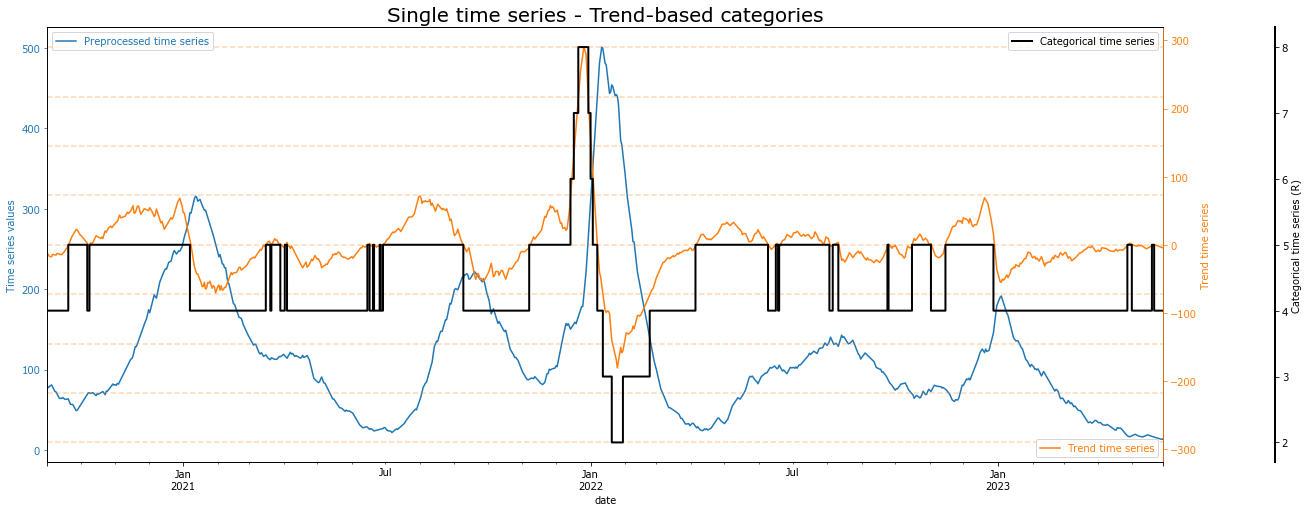

In [5]:
single_ts_workflow(input_ts,workflow_type,freq,fill_method,smooth_window,cat_method,num_bins,win_size)

### Multi Time series(signals)

#### Parameters

In [6]:
### preprocess parameters
fill_method = 'linear'
smooth_window = 7

### categorize parameters
cat_method = 'L-qcut'
num_bins = 5
win_size = 14
#custom_range = (0,500)

In [7]:
workflow_type = 'multi-signal'
freq = 'W'
input_df = pd.read_csv('/Users/vsriniv/Documents/Research/Github/PEpiTA/data/va_cases_cli_viralload.csv',parse_dates=['date'],index_col=0)

            cases_reported  cli_visits  viralload
date                                             
2021-09-12         24987.0     26380.0  28.426552
2021-09-19         22092.0     23494.0  28.086507
2021-09-26         19486.0     21279.0  28.239338
2021-10-03         17243.0     19675.0  27.385247
2021-10-10         14071.0     16433.0  27.755509
...                    ...         ...        ...
2023-04-02          2238.0      9291.0  27.521928
2023-04-09          1734.0      8987.0  27.704354
2023-04-16          1631.0      8758.0  27.375865
2023-04-23          1409.0      8548.0  27.417587
2023-04-30          1477.0      8736.0  26.440917

[86 rows x 3 columns]


**cases_reported**

,category,bin_boundaries,number_of_occurrences,percent_time_spent,average_duration_spent
0,Q1,"(1966.14, 7519.14)",18,20.93%,6.0
1,Q2,"(7519.14, 11590.29)",17,19.77%,2.8
2,Q3,"(11590.29, 16912.71)",17,19.77%,2.8
3,Q4,"(16912.71, 19843.14)",17,19.77%,3.4
4,Q5,"(19843.14, 80100.29)",17,19.77%,5.7


            cases_reported  cli_visits  viralload
date                                             
2021-09-12         24987.0     26380.0  28.426552
2021-09-19         22092.0     23494.0  28.086507
2021-09-26         19486.0     21279.0  28.239338
2021-10-03         17243.0     19675.0  27.385247
2021-10-10         14071.0     16433.0  27.755509
...                    ...         ...        ...
2023-04-02          2238.0      9291.0  27.521928
2023-04-09          1734.0      8987.0  27.704354
2023-04-16          1631.0      8758.0  27.375865
2023-04-23          1409.0      8548.0  27.417587
2023-04-30          1477.0      8736.0  26.440917

[86 rows x 3 columns]


**cli_visits**

,category,bin_boundaries,number_of_occurrences,percent_time_spent,average_duration_spent
0,Q1,"(7374.57, 11771.0)",18,20.93%,9.0
1,Q2,"(11771.0, 15243.43)",17,19.77%,2.8
2,Q3,"(15243.43, 16132.86)",17,19.77%,2.8
3,Q4,"(16132.86, 19492.43)",17,19.77%,2.8
4,Q5,"(19492.43, 36445.71)",17,19.77%,4.2


            cases_reported  cli_visits  viralload
date                                             
2021-09-12         24987.0     26380.0  28.426552
2021-09-19         22092.0     23494.0  28.086507
2021-09-26         19486.0     21279.0  28.239338
2021-10-03         17243.0     19675.0  27.385247
2021-10-10         14071.0     16433.0  27.755509
...                    ...         ...        ...
2023-04-02          2238.0      9291.0  27.521928
2023-04-09          1734.0      8987.0  27.704354
2023-04-16          1631.0      8758.0  27.375865
2023-04-23          1409.0      8548.0  27.417587
2023-04-30          1477.0      8736.0  26.440917

[86 rows x 3 columns]


**viralload**

,category,bin_boundaries,number_of_occurrences,percent_time_spent,average_duration_spent
0,Q1,"(27.29, 27.89)",18,20.93%,6.0
1,Q2,"(27.89, 28.43)",17,19.77%,2.8
2,Q3,"(28.43, 28.95)",17,19.77%,2.8
3,Q4,"(28.95, 29.32)",17,19.77%,2.4
4,Q5,"(29.32, 30.21)",17,19.77%,4.2


,cases_reported,cli_visits,viralload
2021-09-12,Q5,Q5,Q2
2021-09-19,Q5,Q5,Q2
2021-09-26,Q5,Q5,Q2
2021-10-03,Q5,Q5,Q2
2021-10-10,Q4,Q5,Q2
...,...,...,...
2023-04-02,Q1,Q1,Q1
2023-04-09,Q1,Q1,Q1
2023-04-16,Q1,Q1,Q1
2023-04-23,Q1,Q1,Q1


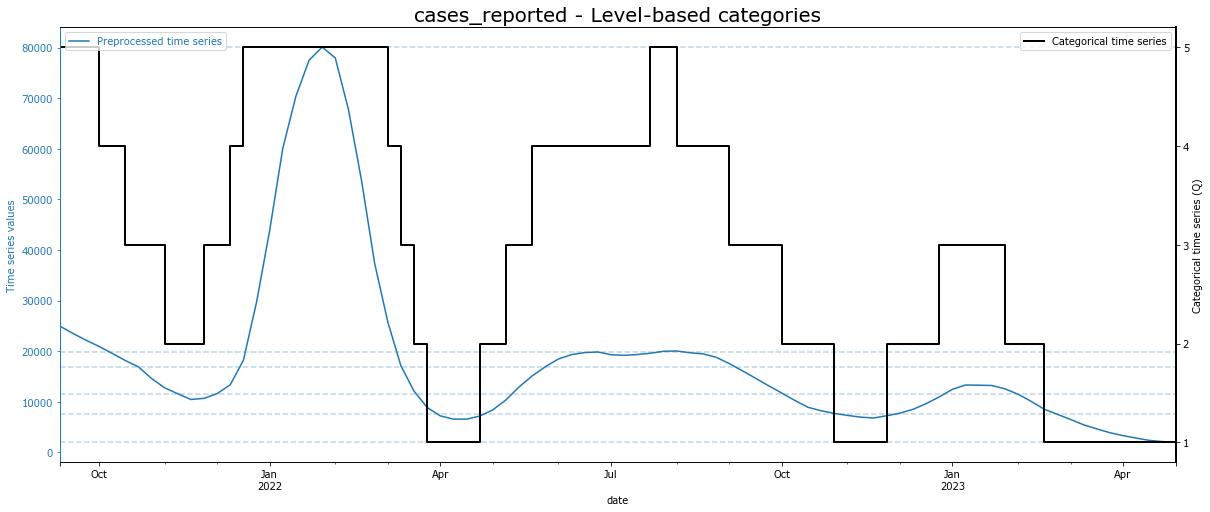

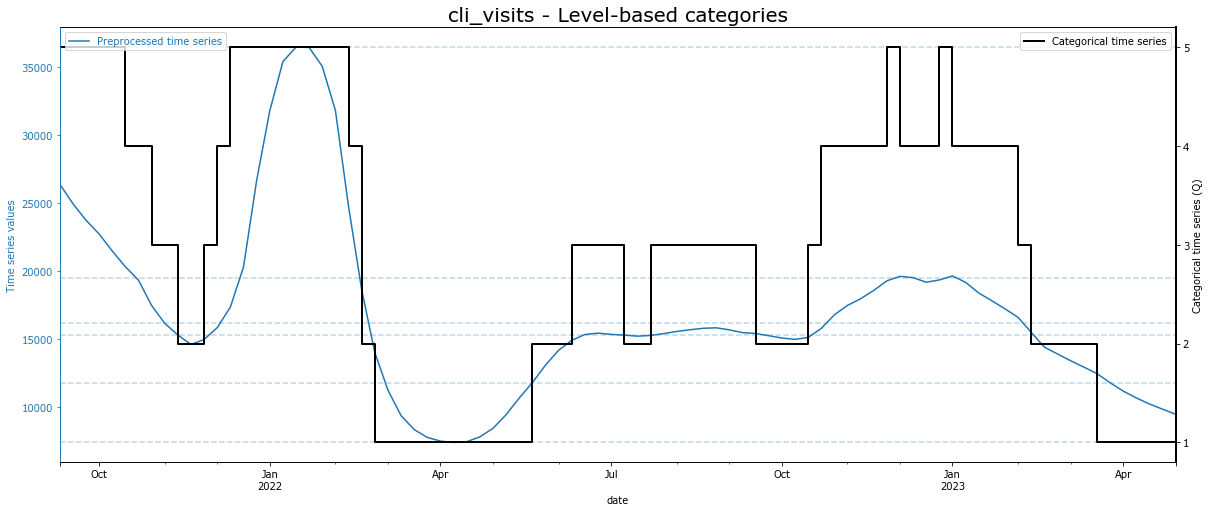

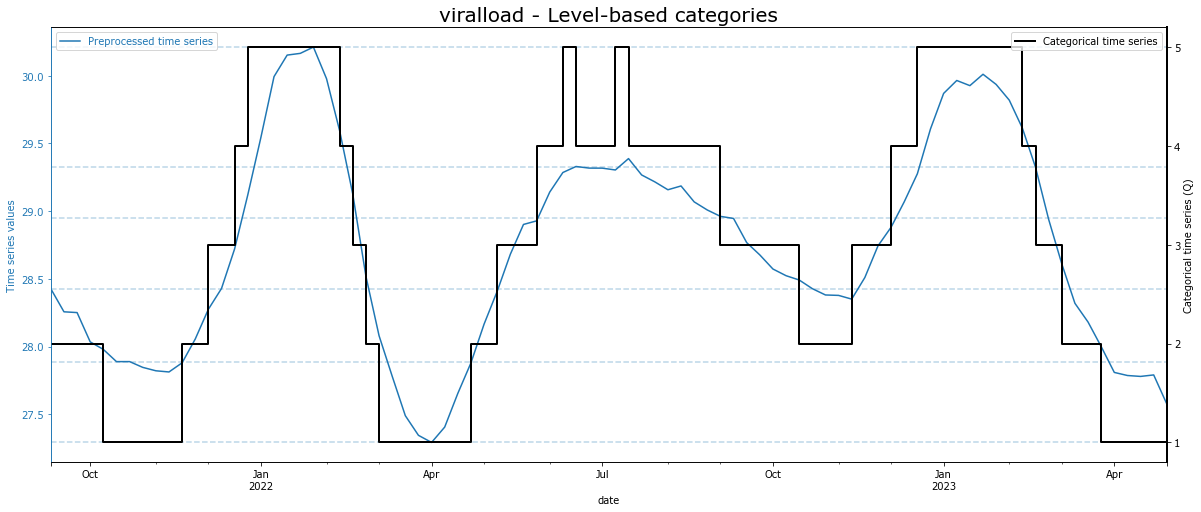

In [8]:
cat_df = pd.DataFrame()
for column in input_df.columns:
    print(input_df)
    signal_ts = input_df[[column]]
    signal_ts.columns = ['value']
    input_ts = signal_ts.reset_index()
    printmd("**"+column+"**")
    single_ts_workflow(input_ts,'single',freq,fill_method,smooth_window,cat_method,num_bins,win_size,title=column)
    cat_ts = single_ts_workflow(input_ts,workflow_type,freq,fill_method,smooth_window,cat_method,num_bins,win_size)
    cat_df = pd.concat([cat_df,cat_ts],axis=1)
cat_df.columns = input_df.columns
cat_df

In [9]:
visualize.multi_signal_plot(cat_df,cat_method)

'20240415191632761291.png'

In [10]:
chi_df, pval_df, csq_str_df = analyze.multi_ts_analyze(cat_df)

In [11]:
visualize.multi_cat_csq(chi_df,csq_str_df)

'20240415191632914806.png'

In [12]:
qfct, cat_fct = forecast.fcast_example()

In [13]:
input_ts

,date,value
0,2021-09-12,28.426552
1,2021-09-19,28.086507
2,2021-09-26,28.239338
3,2021-10-03,27.385247
4,2021-10-10,27.755509
...,...,...
81,2023-04-02,27.521928
82,2023-04-09,27.704354
83,2023-04-16,27.375865
84,2023-04-23,27.417587


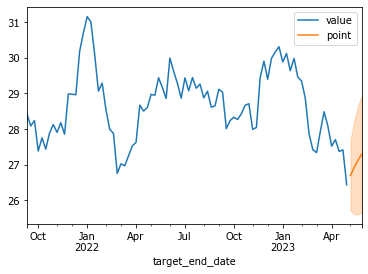

In [18]:
qfct, cat_fct, _ = forecast.ARIMA_func(input_ts[input_ts['date']<=pd.Timestamp('2023-05-01')])
qfct.drop_duplicates(['target_end_date'],inplace=True)

input_ts.plot(x='date',y='value')
ax = plt.gca()
qfct.plot(x='target_end_date',y='point',ax=ax)
ax.fill_between(qfct['target_end_date'].values,qfct['fct_lb'].values,qfct['fct_ub'].values,color='C1',alpha=0.25)

In [19]:
cat_fct

,gt_avl_date,target_end_date,horizon,output_type_id,value
0,2023-04-30,2023-05-07,0,Q1,0.663832
1,2023-04-30,2023-05-07,0,Q2,0.000000
2,2023-04-30,2023-05-07,0,Q3,0.000000
3,2023-04-30,2023-05-07,0,Q4,0.000000
4,2023-04-30,2023-05-07,0,Q5,0.000000
5,2023-04-30,2023-05-14,1,Q1,0.677840
6,2023-04-30,2023-05-14,1,Q2,0.071345
7,2023-04-30,2023-05-14,1,Q3,0.000000
8,2023-04-30,2023-05-14,1,Q4,0.000000
9,2023-04-30,2023-05-14,1,Q5,0.000000


In [20]:
visualize.cat_fcast_plot(cat_fct)

'20240415191912293630.png'

In [21]:
input_ts

,date,value
0,2021-09-12,28.426552
1,2021-09-19,28.086507
2,2021-09-26,28.239338
3,2021-10-03,27.385247
4,2021-10-10,27.755509
...,...,...
81,2023-04-02,27.521928
82,2023-04-09,27.704354
83,2023-04-16,27.375865
84,2023-04-23,27.417587
